In [147]:
import numpy as np
import matplotlib.pyplot as plt

# 配置plt字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'SimSun', 'KaiTi']
plt.rcParams['axes.unicode_minus'] = False

# 加载 .npz 文件
mat_data = np.load(r'D:\神经生物学\20250513核团放电\nuc_v2_split.npz', allow_pickle=True)

# 采样率输入
fs = 1000

# 获取文件中的所有键
print(mat_data.files)

signal_data = mat_data['7900'].flatten()


['2000', 'down_2000-3000', '3000', 'down_3000-4000', '4000', 'down_4000-5000', '5000', 'down_5000-5500', '5500', 'down_5500-6000', '6000', '6500', 'down_6500-6800', '6800', '6900', '6950', '7000', 'down_7000-7060', '7060', '7120', '7200', 'down_7200-7290', '7290', '7357', 'down_7357-7431', '7431', 'down_7431-7500', '7500', 'down_7500-7600', '7600', 'down_7600-7700', '7700', 'down_7700-7800', '7800', 'down_7800-7900', '7900', 'down_7900-down', 'down_down_7900-down-8', '8500', 'down_8500-9000', '9000']


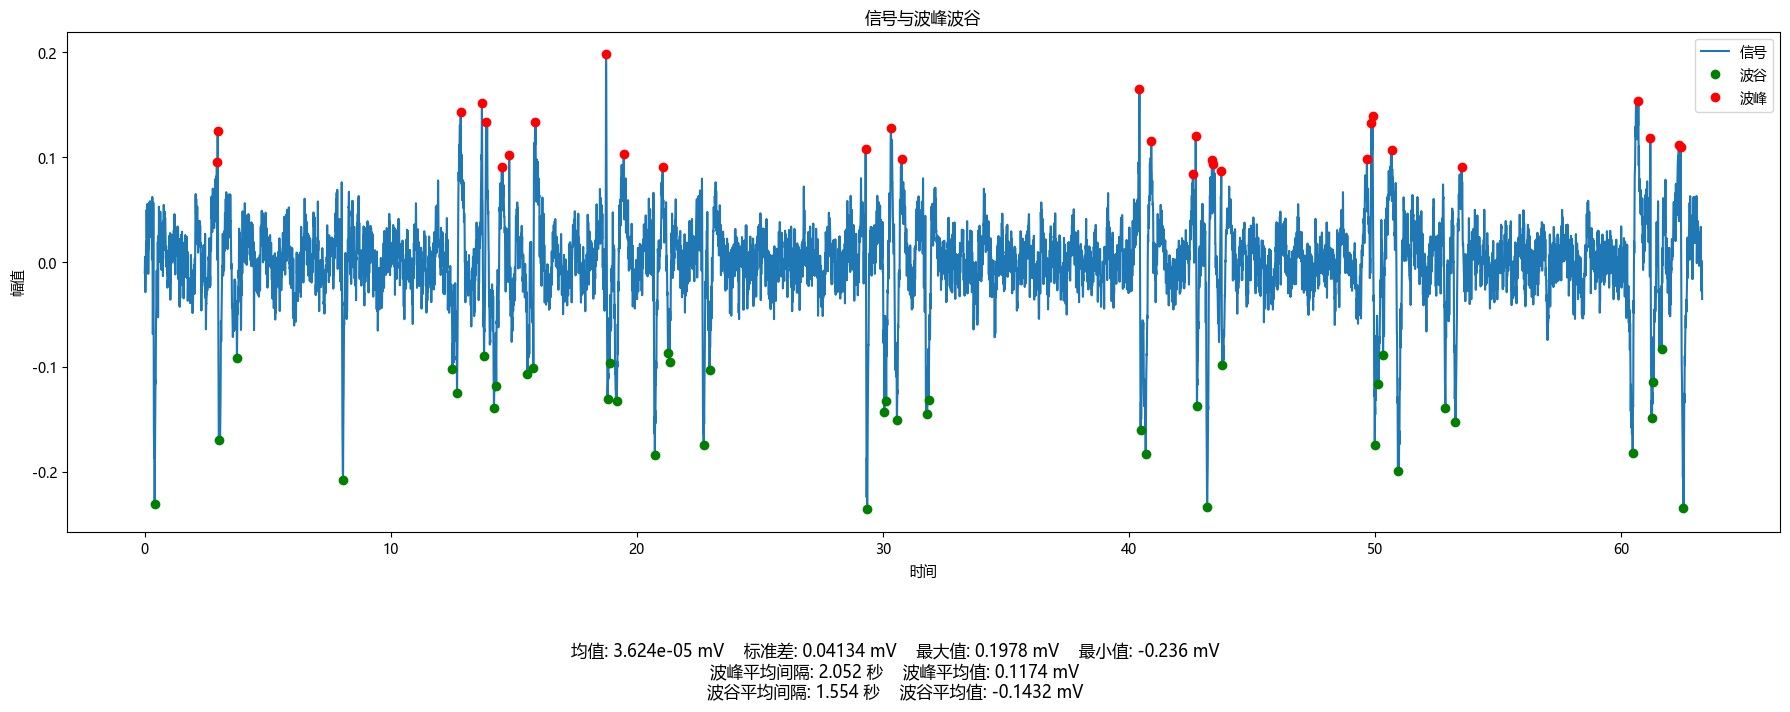

In [148]:
# 峰值检测
from scipy import signal

# 计算信号的统计信息
mean_value = np.mean(signal_data)
std_dev = np.std(signal_data)
max_value = np.max(signal_data)
min_value = np.min(signal_data)

# 自适应波峰检测函数
def find_peaks_auto(signal_data):
    mean_value = np.mean(signal_data)
    std_dev = np.std(signal_data)
    # 计算放电阈值
    threshold =mean_value + 2 * std_dev

    # 建立自适应参数
    peaks_pre, _ = signal.find_peaks(signal_data, height=threshold)
    peak_intervals_pre = np.diff(peaks_pre)
    distance = int(np.median(peak_intervals_pre) * 0.5)
    prominence = 1.0 * np.std(signal_data)

    # 检测波峰
    peaks, properties = signal.find_peaks(signal_data, height=threshold, distance=distance, prominence=prominence)

    return peaks, properties

# 调用自适应波峰检测函数
peaks, _ = find_peaks_auto(signal_data)

# 计算放电的平均间隔时间
peak_intervals = np.diff(peaks) / fs
mean_peak_interval = np.mean(peak_intervals)

# 获取每个波峰的幅值
peak_values = signal_data[peaks]
# 计算波峰的平均最高值
average_peak_value = np.mean(peak_values)
# 输出结果

# 检测波谷
valleys, _ = find_peaks_auto(-signal_data)

# 计算放电的平均间隔时间
valley_intervals = np.diff(valleys) / fs
mean_valley_interval = np.mean(valley_intervals)

# 计算波谷的平均最低值
valley_values = signal_data[valleys]
average_valley_value = np.mean(valley_values)

# 可视化
times = np.arange(len(signal_data)) / fs
plt.figure(figsize=(18, 6))
plt.plot(times, signal_data, label="信号")
plt.plot(times[valleys], valley_values, 'go', label="波谷")
plt.plot(times[peaks], peak_values, 'ro', label="波峰")
plt.xlabel('时间')
plt.ylabel('幅值')
plt.legend()
plt.title('信号与波峰波谷')

# 统计信息文本
stats_text = (
    f"均值: {mean_value:.4g} mV    标准差: {std_dev:.4g} mV    "
    f"最大值: {max_value:.4g} mV    最小值: {min_value:.4g} mV\n"
    f"波峰平均间隔: {mean_peak_interval:.4g} 秒    波峰平均值: {average_peak_value:.4g} mV\n"
    f"波谷平均间隔: {(mean_valley_interval):.4g} 秒    波谷平均值: {average_valley_value:.4g} mV"
)

plt.figtext(0.5, -0.08, stats_text, ha='center', va='top', fontsize=12)
plt.tight_layout()
plt.show()

NFFT: 1024


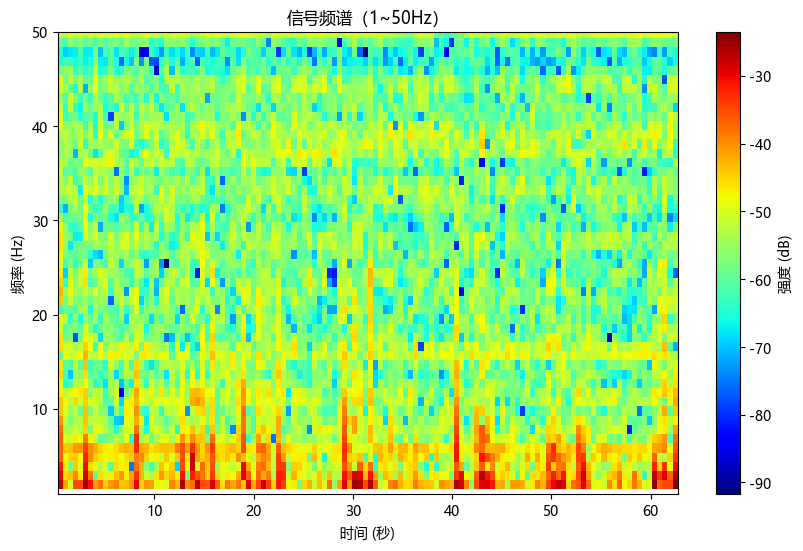

In [149]:
# 计算并绘制频谱
plt.figure(figsize=(10, 6))
# Pxx, freqs, bins, im = plt.specgram(signal_data, Fs=fs, NFFT=1024, noverlap=512, cmap='jet', vmin=-100, vmax=0) # 完整参数
NFFT = 2 ** (int(np.floor(np.log2(len(signal_data))))-5)
print(f'NFFT: {NFFT}')
noverlap = int(NFFT / 2)
Pxx, freqs, bins, im = plt.specgram(signal_data, Fs=fs, NFFT=NFFT, noverlap=noverlap, cmap='jet')

# 选择你需要的频率范围，比如0~30Hz
freq_min = 1
freq_max = 50
freq_mask = (freqs >= freq_min) & (freqs <= freq_max)

# 只显示选定频率范围的数据
plt.clf()  # 清除上一个specgram图
plt.pcolormesh(bins, freqs[freq_mask], 10 * np.log10(Pxx[freq_mask, :]), cmap='jet', shading='auto')
plt.xlabel('时间 (秒)')
plt.ylabel('频率 (Hz)')
plt.title(f'信号频谱（{freq_min}~{freq_max}Hz）')
plt.colorbar(label='强度 (dB)')
plt.ylim(freq_min, freq_max)
plt.show()


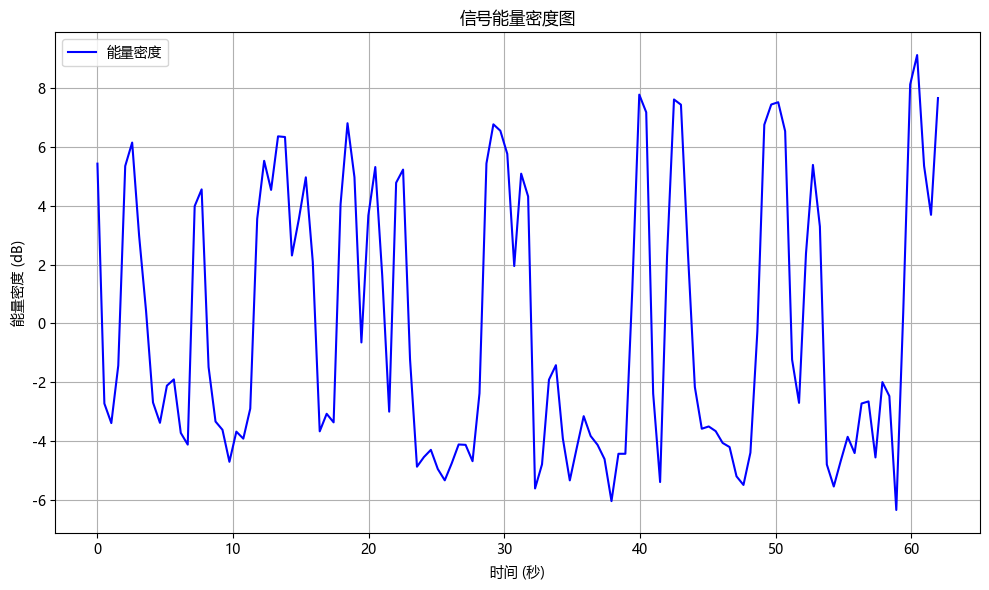

In [162]:
def energy_density_plot(signal_data, fs, window_size=None, overlap=0.5, log_scale=True):
    """
    构建能量密度图
    :param signal_data: 输入的信号数据
    :param fs: 采样率 (Hz)
    :param window_size: 窗口大小 (采样点)
    :param overlap: 窗口重叠比例 (0-1)
    """
    # 计算每个窗口的能量
    if window_size is None or window_size <= 0:
        window_size = 2 ** (int(np.floor(np.log2(len(signal_data))))-5)
    step_size = int(window_size * (1 - overlap))  # 步长
        
    
    
    energies = []
    
    # 使用滑动窗口计算能量
    for start in range(0, len(signal_data) - window_size, step_size):
        end = start + window_size
        window_data = signal_data[start:end]
        energy = np.sum(np.square(window_data))  # 能量 = 信号的平方和
        energies.append(energy)
    
    # 将能量转换为对数尺度（可以选择性地进行）
    energies = np.array(energies)
    if log_scale:
        energies_plt = 10 * np.log10(energies + 1e-6)  # 防止出现对数计算负值的情况
        ylabel = '能量密度 (dB)'
    else:
        energies_plt = energies
        ylabel = '能量密度'
    # 生成时间轴
    times = np.arange(0, len(energies)) * (window_size - step_size) / fs
    
    # 绘制能量密度图
    plt.figure(figsize=(10, 6))
    plt.plot(times, energies_plt, label="能量密度", color='b')
    plt.xlabel('时间 (秒)')
    plt.ylabel(ylabel)
    plt.title('信号能量密度图')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 调用能量密度图函数
energy_density_plot(signal_data, fs, log_scale=True)